Modified from official protocol: https://www.biotite-python.org/latest/examples/gallery/structure/modeling/model_lddt.html#sphx-glr-examples-gallery-structure-modeling-model-lddt-py

Using PDB ID 3THC, chain A as reference structure.
['__abstractmethods__', '__add__', '__class__', '__copy_create__', '__copy_fill__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_annot', '_array_length', '_bonds', '_box', '_coord', '_copy_annotations', '_del_element', '_getitem_new', '_getitem_original', '_repr_lean', '_repr_original', '_set_element', '_subarray', 'add_annotation', 'array_length', 'atom_name', 'bonds', 'box', 'chain_id', 'coord', 'copy', 'del_annotation', 'element', 'equal_annotation_categories', 'equal_annotations', 'get_annotation', 'get_annotation_categories', 'get_atom', 

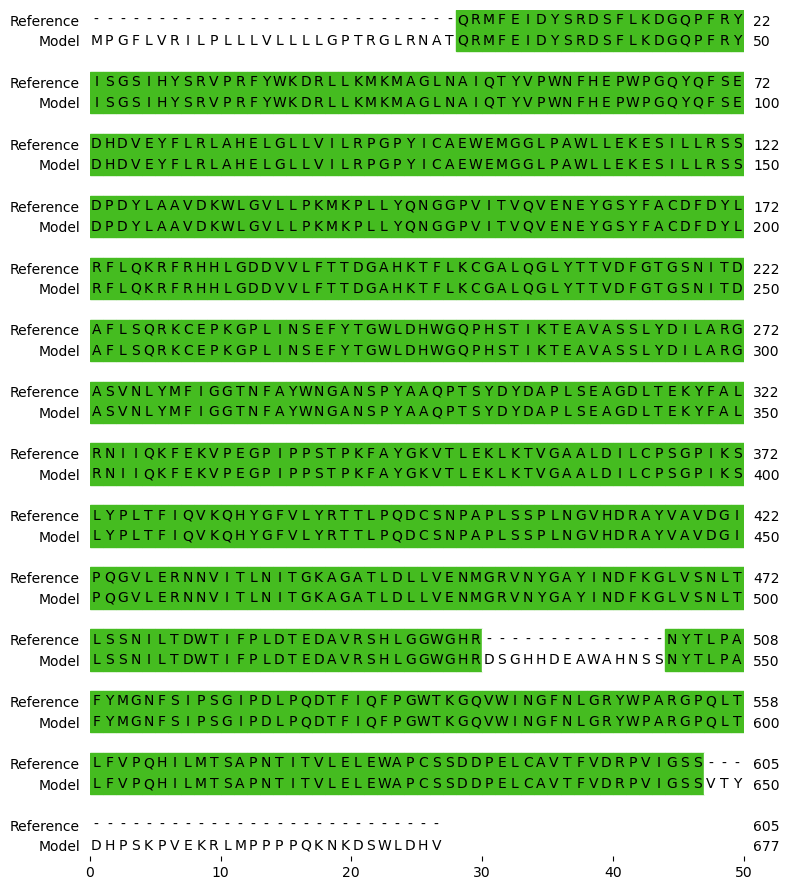

In [ ]:
import biotite.structure.io as strucio
from biotite.structure.io.pdb import PDBFile
import numpy as np
from collections import defaultdict
import biotite.database.afdb as afdb
import biotite.database.rcsb as rcsb
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.structure as struc
import biotite.structure.io.pdbx as pdbx
import matplotlib.pyplot as plt
import biotite.sequence.graphics as graphics

# Uniprot ID of the protein of interest (in this case human beta-galactosidase)
UNIPROT_ID = "P16278"

## Get the reference experimental structure from the PDB
query = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=UNIPROT_ID,
)
# The UniProt ID is defined for a single chain
ids = rcsb.search(query, return_type="polymer_instance")
# Simply use the first matching chain as reference
pdb_id, chain_id = ids[0].split(".")
print(f"Using PDB ID {pdb_id}, chain {chain_id} as reference structure.")

pdb_file = PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
# pdbx_file = pdbx.BinaryCIFFile.read(rcsb.fetch(pdb_id, "bcif"))
reference = pdb_file.get_structure(model=1)
print(dir(reference))
reference = reference[reference.chain_id == chain_id]
# The experimental structure may contain additional small molecules
# (e.g. water, ions etc.) that are not part of the predicted structure
reference = reference[struc.filter_amino_acids(reference)]


## Get the predicted structure from AlphaFold DB
model = PDBFile.read(afdb.fetch(UNIPROT_ID, "pdb")).get_structure(model=1)

## Filter the structures to common atoms that are present in both structures
reference_sequence = struc.to_sequence(reference)[0][0]
model_sequence = struc.to_sequence(model)[0][0]

identity_matrix = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet,
    seq.ProteinSequence.alphabet,
    np.eye(len(seq.ProteinSequence.alphabet), dtype=int),
)
alignment = align.align_optimal(
    reference_sequence,
    model_sequence,
    # Residues might be missing due to experimental reasons but not due to homology
    # -> use a simple identity matrix
    identity_matrix,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Draw first and only alignment
# The color intensity indicates the similiarity
fig = plt.figure(figsize=(8.0, 9.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax,
    alignment,
    matrix=identity_matrix,
    labels=["Reference", "Model"],
    show_numbers=True,
    show_line_position=True,
)
fig.tight_layout()

plt.show()